#Section 6: Recurrent NN

##Name Classification using RNN

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import random

#Neural Network packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import torch.nn.functional as F

# Text packages
import unicodedata
import string

seed = torch.manual_seed(0)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import zipfile
# # unzip image file
# local_zip = '/content/drive/MyDrive/AI-Internship/NameClassification.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content/drive/MyDrive/AI-Internship/NameClassificationn')
# zip_ref.close()

###Data preprocessing

In order to load all files with special address pattern, we use glob library.

In [ ]:
import glob
all_text_files = glob.glob('/content/drive/MyDrive/AI-Internship/NameClassificationn/data/names/*.txt')
print(f'First element of all text files is : {all_text_files[0]}')
print(f'length of all text files is: {len(all_text_files)}')

First element of all text files is : /content/drive/MyDrive/AI-Internship/NameClassificationn/data/names/Arabic.txt
length of all text files is: 18


In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(f'all letters : {all_letters}')
print(f'length of all letters: {len(all_letters)}')

all letters : abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
length of all letters: 57


Because in some languages like French, names are in unicode form, we should convert them to ascii.

In [ ]:
# Fuction for convert names in unicode form to ascii
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Béringer'))

Beringer


We should create a dictionary that keys are languages and values of dictionary are names.

In [ ]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readlines(filename):
  lines = open(filename).read().strip().split('\n')
  return [unicode_to_ascii(line) for line in lines]

for filename in all_text_files:
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  category_lines[category] = readlines(filename)

print(f'There are {len(all_categories)} languages.')
print(f'first 10 examples of {all_categories[0]} names : {category_lines[all_categories[0]][:10]}')

There are 18 languages.
first 10 examples of Arabic names : ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba']


In [ ]:
num_names = 0
for i in all_categories:
  num_names += len(category_lines[i])

print(f'Number of all names : {num_names}')

Number of all names : 20074


#####Convert names to pytorch tensors

In [ ]:
# one hot encoding for a letter
# Find letter index from all_letters
def letter_to_index(letter):
  return all_letters.find(letter)
  
# Turn a line into a <line_length x 1 x n_letters>
def line_to_tensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for i, letter in enumerate(line):
    tensor[i][0][letter_to_index(letter)] = 1
  return tensor
    
print(line_to_tensor('a'))
print(line_to_tensor('a').size())

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 57])


###Buliding RNN

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size , hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)

    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)  


####Testing model

In [ ]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, len(all_categories))

#one step
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)

print(f'input tensor size: {input_tensor.size()}')
print(f'hidden tensor size : {hidden_tensor.size()}')

print(f'output size : {output.size()}')
print(f'next hidden size : {next_hidden.size()}')

input tensor size: torch.Size([6, 1, 57])
hidden tensor size : torch.Size([1, 128])
output size : torch.Size([1, 18])
next hidden size : torch.Size([1, 128])


###Preparing for training

In order to get index of maximum value in output we use the following funciton.

In [ ]:
def category_form_output(output):
  index = torch.argmax(output).item()
  return all_categories[index]

print(category_form_output(output))

Czech


In [ ]:
def randomChoice(list):
  return list[random.randint(0, len(list)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(5):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  print(f'cateogry = {category} | line : {line} |category_tensor size : {category_tensor.size()} | line tensor size : {line_tensor.size()}' )
  

cateogry = English | line : Furnell |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([7, 1, 57])
cateogry = Dutch | line : Haanraats |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([9, 1, 57])
cateogry = Greek | line : Kouretas |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([8, 1, 57])
cateogry = Greek | line : Spyridis |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([8, 1, 57])
cateogry = German | line : Simons |category_tensor size : torch.Size([1]) | line tensor size : torch.Size([6, 1, 57])


###Training the model

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.Adam(rnn.parameters(), lr = learning_rate)
scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)

In [ ]:
def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  optimizer.zero_grad()
  loss.backward()   
  optimizer.step()

  return output, loss.item()

In [ ]:
from tqdm import tqdm 
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in tqdm(range(n_iters)):
  cateory, line, category_tensor, line_tensor = randomTrainingExample()

  output, loss = train(line_tensor, category_tensor)
  current_loss += loss

  scheduler.step() ##

  if (i+1) % plot_steps ==0:
    all_losses.append(current_loss/plot_steps)
    current_loss = 0

  if (i+1) % print_steps ==0:
    guess = category_form_output(output)
    correct = "CORRECT" if guess == category else f"WRONG ({category})"
    print(f'{i+1} |percentage : {(i+1)/n_iters*100} |loss: {loss:.4f} |line: {line} / guess : {guess} {correct}')  



  5%|▌         | 5104/100000 [00:07<02:13, 712.34it/s]

5000 |percentage : 5.0 |loss: 2.7760 |line: Duncan / guess : Arabic WRONG (German)


 10%|█         | 10108/100000 [00:14<02:07, 704.25it/s]

10000 |percentage : 10.0 |loss: 2.7697 |line: D'cruze / guess : Arabic WRONG (German)


 15%|█▌        | 15116/100000 [00:22<02:00, 703.22it/s]

15000 |percentage : 15.0 |loss: 3.1388 |line: Mendez / guess : Arabic WRONG (German)


 20%|██        | 20136/100000 [00:29<01:56, 687.64it/s]

20000 |percentage : 20.0 |loss: 2.6877 |line: Ferro / guess : Arabic WRONG (German)


 25%|██▌       | 25133/100000 [00:37<01:50, 677.41it/s]

25000 |percentage : 25.0 |loss: 3.0764 |line: Bermudez / guess : Arabic WRONG (German)


 30%|███       | 30099/100000 [00:44<01:41, 686.29it/s]

30000 |percentage : 30.0 |loss: 3.0479 |line: Rompuy / guess : Portuguese WRONG (German)


 35%|███▌      | 35104/100000 [00:51<01:33, 694.69it/s]

35000 |percentage : 35.0 |loss: 2.9643 |line: Wen / guess : Vietnamese WRONG (German)


 40%|████      | 40073/100000 [00:59<01:27, 683.20it/s]

40000 |percentage : 40.0 |loss: 2.4761 |line: Hanania / guess : Arabic WRONG (German)


 45%|████▌     | 45131/100000 [01:06<01:20, 684.56it/s]

45000 |percentage : 45.0 |loss: 3.3143 |line: Tanaka / guess : Arabic WRONG (German)


 50%|█████     | 50107/100000 [01:14<01:13, 676.24it/s]

50000 |percentage : 50.0 |loss: 2.8593 |line: Kolovos / guess : Czech WRONG (German)


 55%|█████▌    | 55076/100000 [01:21<01:05, 681.06it/s]

55000 |percentage : 55.00000000000001 |loss: 3.0529 |line: Hiu / guess : Korean WRONG (German)


 60%|██████    | 60099/100000 [01:28<00:57, 696.98it/s]

60000 |percentage : 60.0 |loss: 2.8226 |line: Serafin / guess : Chinese WRONG (German)


 65%|██████▌   | 65070/100000 [01:36<00:52, 668.34it/s]

65000 |percentage : 65.0 |loss: 3.1836 |line: Lockyer / guess : Arabic WRONG (German)


 70%|███████   | 70114/100000 [01:43<00:46, 637.67it/s]

70000 |percentage : 70.0 |loss: 3.0051 |line: O'Leary / guess : Portuguese WRONG (German)


 75%|███████▌  | 75130/100000 [01:51<00:35, 702.32it/s]

75000 |percentage : 75.0 |loss: 2.6397 |line: Rumsey / guess : French WRONG (German)


 80%|████████  | 80113/100000 [01:58<00:29, 680.43it/s]

80000 |percentage : 80.0 |loss: 2.8440 |line: Silveira / guess : Arabic WRONG (German)


 85%|████████▌ | 85074/100000 [02:06<00:25, 575.66it/s]

85000 |percentage : 85.0 |loss: 3.1283 |line: Yau / guess : Vietnamese WRONG (German)


 90%|█████████ | 90109/100000 [02:13<00:14, 674.56it/s]

90000 |percentage : 90.0 |loss: 2.9142 |line: Garrett / guess : Czech WRONG (German)


 95%|█████████▌| 95086/100000 [02:21<00:07, 683.95it/s]

95000 |percentage : 95.0 |loss: 2.9218 |line: Sokolsky / guess : Arabic WRONG (German)


100%|██████████| 100000/100000 [02:28<00:00, 673.76it/s]

100000 |percentage : 100.0 |loss: 2.5766 |line: Lim  / guess : Korean WRONG (German)


????every time we have examples of just one language.

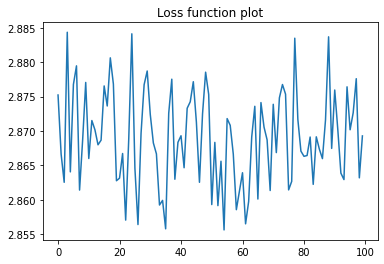

In [ ]:
plt.figure()
plt.plot(all_losses)
plt.title('Loss function plot')
plt.show()

In [ ]:
scheduler.state_dict()

{'_get_lr_called_within_step': False,
 '_last_lr': [0.0],
 '_step_count': 100001,
 'base_lrs': [0.005],
 'gamma': 0.1,
 'last_epoch': 100000,
 'step_size': 30,
 'verbose': False}

In [ ]:
y_actual = []
y_pred = []
n_total = 10000

with torch.no_grad():
  n_true = 0
  n_class_correct = [0 for i in range(18)]
  n_class_sample = [0 for i in range(18)]

  for i in tqdm(range(n_total)):
    cateory, line, category_tensor, line_tensor = randomTrainingExample()

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output, hidden = rnn(line_tensor[i], hidden)

      guess = category_form_output(output)
      y_pred.append(all_categories.index(guess))
      y_actual.append(all_categories.index(category))

      n_true += (guess == category)
      if guess == category :
        n_class_correct[all_categories.index(category)] += 1
      n_class_sample[all_categories.index(category)] += 1
      
  print(f'accuracy of network on the 1000 names is : {(n_true/n_total) *100}')
  
  for i in range(18):
    if n_class_sample[i] != 0:
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {all_categories[i]}: {acc} %')
  

100%|██████████| 10000/10000 [00:05<00:00, 1972.53it/s]

accuracy of network on the 1000 names is : 0.12
Accuracy of German: 0.018977732793522266 %


In [ ]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

###Confusion matrix

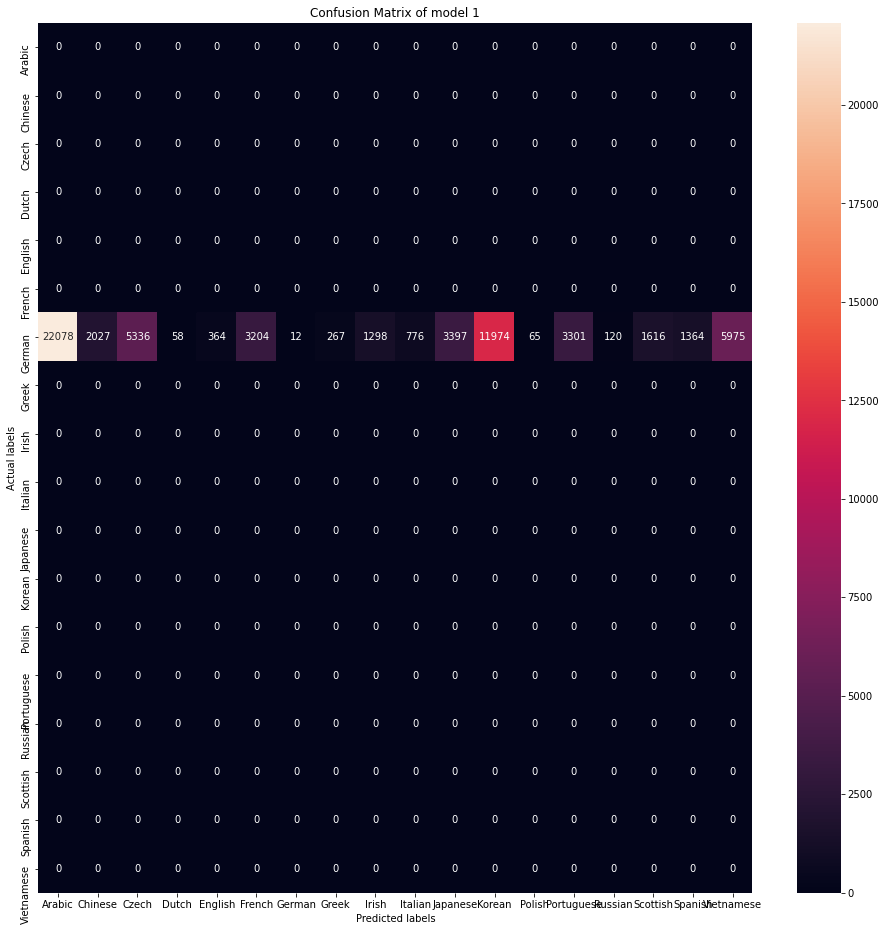

In [ ]:
from sklearn import metrics
import seaborn as sns

plt.figure(figsize = (16,16))
ax= plt.subplot()
cnf_matrix = metrics.confusion_matrix(y_actual, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
ax.set_title('Confusion Matrix of model 1'); 
class_names=['Arabic','Chinese','Czech','Dutch','English','French','German','Greek','Irish','Italian','Japanese','Korean','Polish','Portuguese','Russian','Scottish','Spanish','Vietnamese']
ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);

###Classification report

In [ ]:
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.00      0.00     63232
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

accuracy_confusion matrix

In [ ]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_form_output(output)
        print(guess)

In [ ]:
predict('Austin')


> Austin
Chinese
